In [25]:
import numpy as np
import astropy
from astropy.io import ascii
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table
from matplotlib.colors import LogNorm
from astropy.table import join

# Important file directories:

Source_dir ="C:\\Users\\mspan\\OneDrive - The University of Sydney (Students)\\Honours\\Honours Project\\"
shared_catalogue_filepath = Source_dir +  "SAMI_TOOLS_SMC_MSPA4681\\shared_catalogues\\"


SAMI_spectra_catalogue = "EmissionLine1compDR3.fits"
import all_fctns
import importlib
from all_fctns import *  # your module
importlib.reload(all_fctns)

def refresh_module():
    import importlib
    import all_fctns
    
    importlib.reload(all_fctns)
    

In [85]:

refresh_module()
#required strings and tables: 
catalogue_filepath = Source_dir+"Catalogues\\"
SAMI_spectra_catalogue = "EmissionLine1compDR3.fits"
SAMI_cubeobs_catalogue = "CubeObs.fits"
SAMI_Target_catalogues = ("InputCatGAMADR3.fits", "InputCatClustersDR3.fits", "InputCatFiller.fits")
SAMI_regions = {0: "GAMA", 1: "Clusters", 2: "Filler"}
SAMI_SFR_catalogue = "AR2022_SAMI_DR3_Mstar_SFR_GSWL_rescaled.fits"
OIII_EW_filepath = shared_catalogue_filepath+"O_III_EW_table.fits"


diagnostic_diagrams = ( ('BPT', 'N II'), ('BPT', 'S II'), ('BPT', 'O I'))

source_types = ('RACS',  'LARGESS', 'XRay')
Radio_source_types = ('RACS', 'LARGESS')

Radio_catalogues = "RACS-mid1_sources.fits"
LARGESS_catalogues = "LARGESS.fits"
Xray_catalogues = "eRASS1_Main.v1.1.fits"

# all formatted so keys are the catalogue column names and values are the SAMI summary table column names
RACS_cols_to_include = {'Source_ID': 'RACS_MATCHED_ID', 'Total_flux': 'RACS_TOTALFLUX', 'E_Total_flux': 'RACS_TOTALFLUX_ERR', 'S_Code': 'RACS_SOURCE_CLASSIFICATION'}
LARGESS_cols_to_include = {'Name': 'LARGESS_MATCHED_ID', 'imod': 'LARGESS_imod', 'e_imod': 'LARGESS_e_imod', 
                           'NFIRST':'N_FIRST', 'FFIRST':'FIRST_TOTALFLUX', # FIRST columns from LARGESS
                           'NNVSS':'N_NVSS', 'FNVSS':'NVSS_TOTALFLUX', # NVSS columns from LARGESS             
                            }
eRASS1_cols_to_include = {'IAUNAME': 'eRASS1_MATCHED_ID', 
                           'ML_FLUX_1': 'eRASS1_TOTALFLUX_1', 'ML_FLUX_ERR_1': 'eRASS1_TOTALFLUX_1_ERR', #0.2-2.3 keV band
                           'ML_FLUX_P4': 'eRASS1_TOTALFLUX_2', 'ML_FLUX_ERR_P4': 'eRASS1_TOTALFLUX_2_ERR', #2.0-5.0keV band
                           'ML_FLUX_P6': 'eRASS1_TOTALFLUX_3', 'ML_FLUX_ERR_P6': 'eRASS1_TOTALFLUX_3_ERR', #4.0-10.0keV band
                           } 

# format is Survey_type: (catalogue_filenames, max_sep_arcsec, position_colnames, cols_to_include)
crossmatching_survey_parameters = {'RACS':     ( Radio_catalogues,     5, ('RA', 'Dec'),      RACS_cols_to_include), 
                                   'LARGESS':   ( LARGESS_catalogues,   2, ('RAdeg', 'DEdeg'),  LARGESS_cols_to_include), 
                                   'XRay':      ( Xray_catalogues,     15, ("RA", "DEC"),       eRASS1_cols_to_include)   }




broadline_CATIDs = [137809, 238358, 298590, 323854, 3631902, 376679, 463148, 491508, 718921, 9008500673, 9011900430, 9016800276]
# CATID of broadline AGN in SAMI catalogue - as identified by Scott Croom 


#variables
SN_lim = 5 # signal noise limit for bpt diagrams
rerun_all_files = True
save_file= True  



#Initialise table with first 3 columns: 'CUBEID', 'CUBEIDPUB', 'CATID' from CubeObs
with fits.open(catalogue_filepath+SAMI_cubeobs_catalogue) as SAMI_CubeObs_hdul:
    SAMI_CubeObs_table_hdu =  Table(SAMI_CubeObs_hdul[1].data)
    SAMI_CubeObs_table_hdu.sort('CATID')

Summary_table_hdu = SAMI_CubeObs_table_hdu.copy()
Summary_table_hdu.keep_columns(('CUBEID', 'CUBEIDPUB', 'CATID'))

# get mask of best cubes so only keep the best cubes in summary table
is_best_cube = SAMI_CubeObs_table_hdu['ISBEST']==1
CUBEIDPUB_best_cubes = SAMI_CubeObs_table_hdu[is_best_cube]['CUBEIDPUB']
Summary_table_hdu = Summary_table_hdu[np.isin(Summary_table_hdu['CUBEIDPUB'], CUBEIDPUB_best_cubes)]

# mask out all of the stars
CATID_stars = SAMI_CubeObs_table_hdu['CATID'][SAMI_CubeObs_table_hdu['WARNSTAR']==1]
Summary_table_hdu = Summary_table_hdu[~np.isin(Summary_table_hdu['CATID'], CATID_stars)]

print(999091700201 in Summary_table_hdu['CATID'])


# BPT AGN columns: 

with fits.open(catalogue_filepath+SAMI_spectra_catalogue) as SAMI_spectra_hdul:
    SAMI_spectra_table_hdu = Table(SAMI_spectra_hdul[1].data)
    SAMI_spectra_table_hdu.sort('CATID')

 # initialise a BPT summary table to join with overall summary table
Summary_BPT_table_hdu = SAMI_spectra_table_hdu.copy()
Summary_BPT_table_hdu.keep_columns(('CUBEID', 'CUBEIDPUB', 'CATID'))
Summary_BPT_table_len = len(Summary_BPT_table_hdu)

# the CUBEIDPUB column for the spectra catalogue contains extra whitespace, so remove it
Summary_BPT_table_hdu['CUBEIDPUB'] = [a.strip(' ') for a in Summary_BPT_table_hdu['CUBEIDPUB']]
# same for CUBEID
Summary_BPT_table_hdu['CUBEID'] = [a.strip(' ') for a in Summary_BPT_table_hdu['CUBEID']]



'''
IS_BPT_AGN - Flag to indicate 1.4 arcsec aperture emission data is located within the AGN region in a O[III]/[H\beta] v [NII]/[H\alpha] BPT diagram as defined in (Kewley, 2001)
CATEGORY_BPT_AGN - Region galaxies 1.4 arcsec aperture emission data is located in on O[III]/[H\beta] v [NII]/[H\alpha] BPT diagram. Integer value is based on region in BPT:
            -1 - S/N above threshold or no spectra for both axes \\
            0 - Star-forming \\
			1 - located on Star-forming / Composite region boundary \\
			2 - Composite \\
			3 - located on Composite / AGN region boundary \\
            4 - Located Across Star-forming / Composite / AGN regions \\
            5 - Located on Star-forming / AGN region boundary before intercept point in NII BPT\\
			6 - LINER \\
			7 - Seyfert \\
			8 - located on LINER / Seyfert boundary \\
            9 - AGN based only on O III / H\\beta \\
            10 - AGN based only on {metal} / H\\alpha \\             
IS_POSSIBLE_BPT_AGN - Flag to indicate 1.4 arcsec aperture emission data is located within AGN region in either [SII] or [OI] BPT diagrams as defined in (Kewley, 2001)
WARN_BPT_SN	- Flag to indicate high-S/N (>5) of 1.4 arcsec aperture emission data used in O[III]/[H\beta] v [NII]/[H\alpha] BPT plot
WARN_AGN_OTHER_BPT - Flag to indicate galaxy emission data is not located in AGN region in [SII]/[H\alpha] or [OI]/[H\alpha] BPT plots defined in (Kewley, 2001) 
WARN_AGN_TYPE_OTHER_BPT - Flag to indicate galaxy emission data is not located in the same AGN type region in [SII]/[H\alpha] or [OI]/[H\alpha] BPT plots compared to [NII]/[H\alpha] BPT classification, bounds defined in (Kewley, 2006)
'''


OIII_flux, OIII_error = all_fctns.get_flux_and_error_1_4_ARCSEC(SAMI_spectra_table_hdu, 'O III')
HBeta_flux, HBeta_error = all_fctns.get_flux_and_error_1_4_ARCSEC(SAMI_spectra_table_hdu, 'H Beta')
HAlpha_flux, HAlpha_error = all_fctns.get_flux_and_error_1_4_ARCSEC(SAMI_spectra_table_hdu, 'H Alpha')


    # initialise arrays for other BPT diagrams:
other_AGN_array = np.zeros(Summary_BPT_table_len, dtype=bool)
Warning_not_AGN_other_BPT_array = np.zeros(Summary_BPT_table_len, dtype=bool)
Warning_different_AGN_type_other_BPT_array = np.zeros(Summary_BPT_table_len, dtype=bool)

for diagnostic_diagram in diagnostic_diagrams:
    plot_type = diagnostic_diagram[0]
    bpt_metal = diagnostic_diagram[1]

    metal_flux, metal_error = all_fctns.get_flux_and_error_1_4_ARCSEC(SAMI_spectra_table_hdu, bpt_metal)

    BPT_y = OIII_flux/HBeta_flux
    BPT_x = metal_flux/HAlpha_flux

    BPT_y_error = np.abs(BPT_y * np.sqrt( (OIII_error/OIII_flux)**2+(HBeta_error/HBeta_flux)**2))
    BPT_x_error = np.abs(BPT_x * np.sqrt( (metal_error/metal_flux)**2+(HAlpha_error/HAlpha_flux)**2))

    SN_array = np.max(np.array([BPT_y_error/BPT_y, BPT_x_error/BPT_x]), axis=0)

    SN_flag = SN_array > SN_lim

    galaxy_type_array, is_AGN_array = all_fctns.get_BPT_AGN_classification(BPT_x, BPT_x_error, BPT_y, BPT_y_error, metal = bpt_metal)
    if bpt_metal == 'N II':
        # set these array values as they will be used later to build the main BPT columns
        Category_BPT_array = galaxy_type_array.copy()
        Is_BPT_array = is_AGN_array.copy()
        Warning_BPT_SN_array = SN_flag.copy()

    else:
        # update possible AGN array if is AGN in other BPT
        other_AGN_array = other_AGN_array | is_AGN_array 

        # update warning if not an AGN in other BPT (only if was originally considered an AGN)
        Warning_not_AGN_other_BPT_array = Warning_not_AGN_other_BPT_array | (~is_AGN_array & Is_BPT_array) 

        # update warning if different type of AGN in other BPT
        same_AGN_type_array =  (Category_BPT_array == galaxy_type_array)
        Warning_different_AGN_type_other_BPT_array = Warning_different_AGN_type_other_BPT_array | (~same_AGN_type_array & Is_BPT_array) 

# IS_BPT_AGN
Summary_BPT_table_hdu.add_column(astropy.table.Column(Is_BPT_array, name=f'IS_BPT_AGN', dtype=int))

# CATEGORY_BPT_AGN
Summary_BPT_table_hdu.add_column(astropy.table.Column(Category_BPT_array, name=f'CATEGORY_BPT_AGN', dtype=int))

# IS_OTHER_BPT_AGN
Summary_BPT_table_hdu.add_column(astropy.table.Column(other_AGN_array, name=f'IS_OTHER_BPT_AGN', dtype=int))

# WARN_BPT_SN
Summary_BPT_table_hdu.add_column(astropy.table.Column(Warning_BPT_SN_array, name=f'WARN_BPT_SN', dtype=int))

# WARN_AGN_OTHER_BPT
Summary_BPT_table_hdu.add_column(astropy.table.Column(Warning_not_AGN_other_BPT_array, name=f'WARN_AGN_OTHER_BPT', dtype=int))

# WARN_AGN_TYPE_OTHER_BPT
Summary_BPT_table_hdu.add_column(astropy.table.Column(Warning_different_AGN_type_other_BPT_array, name=f'WARN_AGN_TYPE_OTHER_BPT', dtype=int))

Summary_table_hdu= join(Summary_table_hdu, Summary_BPT_table_hdu, keys=('CUBEIDPUB', 'CATID', 'CUBEID'), join_type='left')





# CROSS-MATCHING Columns

    # Use previously constructed catalogue summary table functions

# intialise a column of zeros for IS_RADIOSOURCE
Summary_table_hdu.add_column(astropy.table.Column(np.zeros(len(Summary_table_hdu), dtype=int), name='IS_RADIOSOURCE', dtype=int))

# iterate for every column
for source_type in source_types:
    #expand tuple of crossmatching_params
    crossmatching_catalogue, max_sep_arcsec, position_colnames, cols_to_include = crossmatching_survey_parameters[source_type]

    # initialise array of is_in 

    crossmatched_catalogue = all_fctns.get_all_SAMI_crossmatched_fits_table(Source_dir+"Catalogues\\", crossmatching_catalogue, max_sep_arcsec, position_colnames, save_file=False, only_closest=False, survey_cols_to_keep=cols_to_include, rerun_all_files=rerun_all_files)
    print(len(crossmatched_catalogue))
# IS_{source_type}SOURCE         
    cube_is_crossmatched = np.isin(Summary_table_hdu['CATID'],crossmatched_catalogue['CATID'])*1    
    print(f"Number of {source_type} matches: {np.sum(cube_is_crossmatched)}")

    Summary_table_hdu.add_column(astropy.table.Column(cube_is_crossmatched, name=f'IS_{source_type.upper()}SOURCE', dtype=int))
# add the columnss for each catalogue
    Summary_table_hdu = join(Summary_table_hdu, crossmatched_catalogue[('CATID',)+ tuple(cols_to_include.keys())], join_type='left')
    
# Rename these columns
    Summary_table_hdu.rename_columns(tuple(cols_to_include.keys()), tuple(cols_to_include.values()))

# fix the IS_RADIOSOURCE column to be 1 if either RACS or LARGESS matched
    if source_type in Radio_source_types:
        Summary_table_hdu['IS_RADIOSOURCE'] = np.maximum(Summary_table_hdu['IS_RADIOSOURCE'], cube_is_crossmatched)


# Add a HERG/LERG column for radio matches based on O_III_EW_table
with fits.open(OIII_EW_filepath) as OIII_EW_hdul:
    OIII_EW_table = Table(OIII_EW_hdul[1].data)
    OIII_EW_table.sort('CATID')

    # reduce to only those with radio matches
OIII_EW_table = OIII_EW_table[np.isin(OIII_EW_table['CATID'], Summary_table_hdu['CATID'][Summary_table_hdu['IS_RADIOSOURCE']==1])]

OIII_EW_lim = 5 # Angstroms
OIII_SN_lim = 3 # signal to noise limit for O III line
# initialise table of HERG/LERG values
HERG_LERG_table = Table(names=('CATID', 'IS_HERG'), dtype=(int, int))

for catid in OIII_EW_table['CATID']:
    # get O III emission line flux
    OIII_flux, OIII_error = all_fctns.get_flux_and_error_1_4_ARCSEC(SAMI_spectra_table_hdu, 'O III', catid=catid)
    # print(len(SAMI_spectra_table_hdu[SAMI_spectra_table_hdu=='catid']))
    # print(catid, OIII_flux, OIII_error)

    # check if O III flux is above SN limit
    OIII_SN = OIII_flux/OIII_error

    if OIII_SN < OIII_SN_lim: # inconclusive if below SN limit
        is_herg = -1
    
    else: # get O III EW value
        OIII_EW = OIII_EW_table['O_III_EW_LineFit'][OIII_EW_table['CATID']==catid]
        if OIII_EW >= OIII_EW_lim:
            is_herg = 1 # is HERG
        else:
            is_herg = 0 # is LERG

    HERG_LERG_table.add_row((catid, is_herg))

# IS_HERG
Summary_table_hdu = join(Summary_table_hdu, HERG_LERG_table, keys='CATID', join_type='left')



    # add column for broadline AGN
is_broadline_AGN = np.isin(Summary_table_hdu['CATID'], broadline_CATIDs)*1

# IS_BROADLINE_AGN
Summary_table_hdu.add_column(astropy.table.Column(is_broadline_AGN, name=f'IS_BROADLINE_AGN', dtype=int))


# ------ EASE OF USE COLUMNS ------
all_SAMI_Targets_table = all_fctns.get_all_SAMI_targets_catalogue(catalogue_filepath, save_file=False)

# add a column for the stellar mass
Summary_table_hdu = join(Summary_table_hdu, all_SAMI_Targets_table[('CATID', 'Mstar')], keys='CATID', join_type='left')
                         
# M_STAR
Summary_table_hdu.rename_column('Mstar', 'M_STAR')

# add a column for the best redshift
z_spec_table = all_fctns.get_z_best(catalogue_filepath, Summary_table_hdu['CATID'])

# Z_SPEC
Summary_table_hdu = join(Summary_table_hdu, z_spec_table, keys='CATID', join_type='left')

# add a column for the region which is already in the ALL_SAMI_Targets catalogue
reduced_all_SAMI_Targets_table = all_SAMI_Targets_table.copy()
reduced_all_SAMI_Targets_table.keep_columns(('CATID', 'SAMI_REGION'))
Summary_table_hdu = join(Summary_table_hdu, reduced_all_SAMI_Targets_table, keys='CATID', join_type='left')

# add a column for the SFR (from the SAMI SFR catalogue)

with fits.open(catalogue_filepath + SAMI_SFR_catalogue) as SAMI_SFR_hdul:
    SAMI_SFR_table = Table(SAMI_SFR_hdul[1].data)

CATID_SFR_table = all_fctns.get_SAMI_SFRs(Summary_table_hdu, SAMI_SFR_table)
Summary_table_hdu = join(Summary_table_hdu, CATID_SFR_table, join_type='left')


# SFR_SAMI
Summary_table_hdu.rename_column('SFR_best', 'SFR_SAMI')
# SFR_SAMI_FLAG
Summary_table_hdu.rename_column('SFR_best_flag', 'SFR_SAMI_FLAG')



save_file = True
overwrite = True
if save_file:
    Summary_table_filename = f"SAMI_AGN_matches.fits"

    Summary_table_filepath = catalogue_filepath+"Crossmatched\\"+Summary_table_filename
    Summary_table_hdu.write(Summary_table_filepath, overwrite=overwrite)
    print(f"Summary Table Saved to: {Summary_table_filepath}")

    git_summary_table_filepath = Source_dir+"sami_tools_smc_mspa4681\\shared_catalogues\\"
    Summary_table_hdu.write(git_summary_table_filepath+Summary_table_filename, overwrite=overwrite)
    print(f"Summary Table Saved to: {git_summary_table_filepath+Summary_table_filename}")

Summary_table_hdu

False


c:\Users\mspan\OneDrive - The University of Sydney (Students)\Honours\Honours Project\sami_tools_smc_mspa4681\Code\all_fctns.py:196: RuntimeWarning: invalid value encountered in log10
  logBPT_y_min = np.log10(BPT_y - BPT_y_error)
c:\Users\mspan\OneDrive - The University of Sydney (Students)\Honours\Honours Project\sami_tools_smc_mspa4681\Code\all_fctns.py:199: RuntimeWarning: invalid value encountered in log10
  logBPT_x_min = np.log10(BPT_x - BPT_x_error)


Rerunning all files to produce new crossmatched catalogue.
Combine SAMI Targets Table Saved to: C:\Users\mspan\OneDrive - The University of Sydney (Students)\Honours\Honours Project\Catalogues\ALL_SAMI_TARGETS.fits
Cutout saved to C:\Users\mspan\OneDrive - The University of Sydney (Students)\Honours\Honours Project\Catalogues\SAMI_target_regions_cutout_RACS-mid1_sources.fits
197
Number of RACS matches: 197
Rerunning all files to produce new crossmatched catalogue.
Combine SAMI Targets Table Saved to: C:\Users\mspan\OneDrive - The University of Sydney (Students)\Honours\Honours Project\Catalogues\ALL_SAMI_TARGETS.fits
Cutout saved to C:\Users\mspan\OneDrive - The University of Sydney (Students)\Honours\Honours Project\Catalogues\SAMI_target_regions_cutout_LARGESS.fits
107
Number of LARGESS matches: 107
Rerunning all files to produce new crossmatched catalogue.
Combine SAMI Targets Table Saved to: C:\Users\mspan\OneDrive - The University of Sydney (Students)\Honours\Honours Project\Catal

CUBEIDPUB,CUBEID,CATID,IS_BPT_AGN,CATEGORY_BPT_AGN,IS_OTHER_BPT_AGN,WARN_BPT_SN,WARN_AGN_OTHER_BPT,WARN_AGN_TYPE_OTHER_BPT,IS_RADIOSOURCE,IS_RACSSOURCE,RACS_MATCHED_ID,RACS_TOTALFLUX,RACS_TOTALFLUX_ERR,RACS_SOURCE_CLASSIFICATION,IS_LARGESSSOURCE,LARGESS_MATCHED_ID,LARGESS_imod,LARGESS_e_imod,N_FIRST,FIRST_TOTALFLUX,N_NVSS,NVSS_TOTALFLUX,IS_XRAYSOURCE,eRASS1_MATCHED_ID,eRASS1_TOTALFLUX_1,eRASS1_TOTALFLUX_1_ERR,eRASS1_TOTALFLUX_2,eRASS1_TOTALFLUX_2_ERR,eRASS1_TOTALFLUX_3,eRASS1_TOTALFLUX_3_ERR,IS_HERG,IS_BROADLINE_AGN,M_STAR,Z_SPEC,SAMI_REGION,SFR_SAMI,SFR_SAMI_FLAG
str16,str80,int64,int64,int64,int64,int64,int64,int64,int64,int64,str17,float64,float64,str1,int64,str19,float64,float64,int64,float64,int64,float64,int64,str23,float32,float32,float32,float32,float32,float32,int64,int64,float32,float64,str8,float64,float64
6821_A,6821_7_Y18SAR4_P001_12T126_2018_05_07-2018_05_16,6821,0,0,1,0,0,0,0,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,--,0,7.42,0.004430000204592943,GAMA,-0.8337829957020938,2.0
6837_A,6837_7_Y18SAR4_P001_12T126_2018_05_07-2018_05_16,6837,0,0,0,0,0,0,0,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,--,0,--,0.07423999905586243,Filler,-0.10811913977560492,1.0
7139_A,7139_7_Y18SAR3_P002_12T122_2018_05_07-2018_05_16,7139,1,6,1,0,0,0,0,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,--,0,10.63,0.07697000354528427,GAMA,-1.4812175131637677,0.0
7206_A,7206_7_Y18SAR3_P002_12T122_2018_05_07-2018_05_16,7206,0,2,0,0,0,0,0,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,--,0,10.48,0.09470999985933304,GAMA,0.5071057664992104,0.0
7289_A,7289_7_Y18SAR3_P002_12T122_2018_05_07-2018_05_16,7289,1,10,1,0,1,1,0,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,--,0,11.12,0.08812999725341797,GAMA,-0.42963751393666283,0.0
7715_A,7715_7_Y14SAR4_P002_12T064_2014_05_23-2014_06_01,7715,0,-1,1,0,0,0,0,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,--,0,10.99,0.07926999777555466,GAMA,-0.9876825301304426,0.0
7839_A,7839_7_Y16SAR4_P002_12T101_2017_04_19-2017_05_01,7839,1,6,1,0,1,1,1,0,--,--,--,--,1,J115827.70+004304.4,14.397,0.002,1,1.35,0,-99.0,0,--,--,--,--,--,--,--,0,0,11.05,0.048739999532699585,GAMA,-0.9330332098451861,1.0
7841_A,7841_7_Y14SAR4_P002_12T064_2014_05_23-2014_06_01,7841,0,-1,0,0,0,0,1,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,-1,0,10.96,0.0798100009560585,GAMA,-1.3503192190613338,0.0
7946_A,7946_7_Y16SAR4_P002_12T101_2017_04_19-2017_05_01,7946,1,6,1,0,1,1,0,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,--,0,10.92,0.10426999628543854,GAMA,0.07435618623620215,0.0


In [87]:
refresh_module()
print("Number of SAMI galaxies in summary table:", len(Summary_table_hdu))
print("Number of radio sources in summary table:", np.sum(Summary_table_hdu['IS_RADIOSOURCE']==1))

print("Number of radio sources with HERG/LERG classification:", len(OIII_EW_table))
print("num of HERGs:", np.sum(HERG_LERG_table['IS_HERG']==1))
print("num of LERGs:", np.sum(HERG_LERG_table['IS_HERG']==0))
print("num of inconclusive:", np.sum(HERG_LERG_table['IS_HERG']==-1))

print([region for region in SAMI_regions.values()])
print([np.sum(Summary_table_hdu['IS_LARGESSSOURCE'] & (Summary_table_hdu['SAMI_REGION'] == region)) for region in SAMI_regions.values()])
print([np.sum(Summary_table_hdu['IS_RACSSOURCE'] & (Summary_table_hdu['SAMI_REGION'] == region)) for region in SAMI_regions.values()])


print([np.sum(Summary_table_hdu['IS_RADIOSOURCE'] & (Summary_table_hdu['SAMI_REGION'] == region)) for region in SAMI_regions.values()])

Summary_table_hdu[Summary_table_hdu['IS_RADIOSOURCE']==1 & ~ np.isin(Summary_table_hdu['SAMI_REGION'], SAMI_regions.values())]
Summary_table_hdu[(Summary_table_hdu['IS_RADIOSOURCE']==1) & ~ (Summary_table_hdu['SAMI_REGION']== 'GAMA') & ~ (Summary_table_hdu['SAMI_REGION']== 'Clusters') & ~ (Summary_table_hdu['SAMI_REGION']== 'Filler')]
np.sum([SAMI_CubeObs_table_hdu['WARNSTAR']==1])

Number of SAMI galaxies in summary table: 3068
Number of radio sources in summary table: 299
Number of radio sources with HERG/LERG classification: 299
num of HERGs: 60
num of LERGs: 207
num of inconclusive: 32
['GAMA', 'Clusters', 'Filler']
[np.int64(97), np.int64(10), np.int64(0)]
[np.int64(151), np.int64(46), np.int64(0)]
[np.int64(242), np.int64(53), np.int64(4)]


np.int64(286)

In [15]:
test = Summary_table_hdu[Summary_table_hdu['IS_RADIOSOURCE']==1]
test[test['CATID']==9011900430]

CUBEIDPUB,CUBEID,CATID,IS_BPT_AGN,CATEGORY_BPT_AGN,IS_OTHER_BPT_AGN,WARN_BPT_SN,WARN_AGN_OTHER_BPT,WARN_AGN_TYPE_OTHER_BPT,IS_RADIOSOURCE,RACS_MATCHED_ID,RACS_TOTALFLUX,RACS_TOTALFLUX_ERR,RACS_SOURCE_CLASSIFICATION,IS_XRAYSOURCE,eROSITA_MATCHED_ID,eROSITA_TOTALFLUX_1,eROSITA_TOTALFLUX_1_ERR,eROSITA_TOTALFLUX_2,eROSITA_TOTALFLUX_2_ERR,eROSITA_TOTALFLUX_3,eROSITA_TOTALFLUX_3_ERR,IS_LARGESSSOURCE,LARGESS_MATCHED_ID,LARGESS_imod,LARGESS_e_imod,N_FIRST,FIRST_TOTALFLUX,N_NVSS,NVSS_TOTALFLUX,IS_BROADLINE_AGN,M_STAR,Z_SPEC,SFR_SAMI,SFR_SAMI_FLAG
str16,str80,int64,int64,int64,int64,int64,int64,int64,int64,str17,float64,float64,str1,int64,str23,float32,float32,float32,float32,float32,float32,int64,str19,float64,float64,int64,float64,int64,float64,int64,float32,float64,float64,float64
9011900430_A,9011900430_7_Y15SBR2_P006_A0119T035_2016_09_28-2016_10_04,9011900430,1,6,1,0,0,1,1,RACS_0104+00_2817,5618.47763012387,337.40456003808833,M,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,1,11.389562,0.0451924093067646,nan,nan


In [5]:
unique= np.unique(Summary_table_hdu['CATEGORY_BPT_AGN'])
print(unique[-1])

Summary_table_hdu[Summary_table_hdu['CATEGORY_BPT_AGN'] == unique[-1]]

--


CUBEIDPUB,CUBEID,CATID,IS_BPT_AGN,CATEGORY_BPT_AGN,IS_OTHER_BPT_AGN,WARN_BPT_SN,WARN_AGN_OTHER_BPT,WARN_AGN_TYPE_OTHER_BPT,IS_RADIOSOURCE,RACS_MATCHED_ID,RACS_TOTALFLUX,RACS_TOTALFLUX_ERR,RACS_SOURCE_CLASSIFICATION,IS_XRAYSOURCE,eROSITA_MATCHED_ID,eROSITA_TOTALFLUX_1,eROSITA_TOTALFLUX_1_ERR,eROSITA_TOTALFLUX_2,eROSITA_TOTALFLUX_2_ERR,eROSITA_TOTALFLUX_3,eROSITA_TOTALFLUX_3_ERR,IS_LARGESSSOURCE,LARGESS_MATCHED_ID,LARGESS_imod,LARGESS_e_imod,N_FIRST,FIRST_TOTALFLUX,N_NVSS,NVSS_TOTALFLUX,IS_BROADLINE_AGN,M_STAR,Z_SPEC,SFR_SAMI,SFR_SAMI_FLAG
str16,str80,int64,int64,int64,int64,int64,int64,int64,int64,str17,float64,float64,str1,int64,str23,float32,float32,float32,float32,float32,float32,int64,str19,float64,float64,int64,float64,int64,float64,int64,float32,float64,float64,float64
99513_A,99513_7_Y15SAR3_P006_12T097_2017_04_19-2017_05_01,99513,--,--,--,--,--,--,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,0,8.42,0.021530000492930412,-1.408317252899234,1.0
10000001_A,10000001_7_Y14SAR2_P007_09T074_2017_02_27-2017_03_05,10000001,--,--,--,--,--,--,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,0,--,nan,--,--
10000002_A,10000002_7_Y14SAR1_P005_09T065_2015_02_16-2015_02_25,10000002,--,--,--,--,--,--,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,0,--,nan,--,--
10000004_A,10000004_7_Y15SAR1_P001_09T097_2016_03_03-2016_03_13,10000004,--,--,--,--,--,--,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,0,--,nan,--,--
10000010_A,10000010_7_Y16SAR2_P003_09T122_2017_03_24-2017_04_02,10000010,--,--,--,--,--,--,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,0,--,nan,--,--
10000014_A,10000014_11_Y13SAR1_P004_09T018_2013_03_05-2013_03_17,10000014,--,--,--,--,--,--,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,0,--,nan,--,--
10000016_B,10000016_7_Y16SAR2_P002_09T117_2016_03_03-2016_03_13,10000016,--,--,--,--,--,--,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,0,--,nan,--,--
10000017_A,10000017_6_Y14SAR2_P004_09T071_2014_04_02-2014_04_06,10000017,--,--,--,--,--,--,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,0,--,nan,--,--
10000021_A,10000021_7_Y15SAR2_P002_09T110_2016_02_08-2016_02_14,10000021,--,--,--,--,--,--,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,0,--,nan,--,--


In [6]:
refresh_module()




with fits.open(Source_dir +"Catalogues\\" + SAMI_SFR_catalogue) as SAMI_SFR_hdul:
    SAMI_SFR_table = Table(SAMI_SFR_hdul[1].data)

SFR_array = get_SAMI_SFRs(Summary_table_hdu, SAMI_SFR_table)
SFR_array



CATID,SFR_best,SFR_best_flag
int64,float64,float64
6821,-0.8337829957020938,2.0
6837,-0.10811913977560492,1.0
7139,-1.4812175131637677,0.0
7206,0.5071057664992104,0.0
7289,-0.42963751393666283,0.0
7715,-0.9876825301304426,0.0
7839,-0.9330332098451861,1.0
7841,-1.3503192190613338,0.0
7946,0.07435618623620215,0.0


In [7]:
('CATID',)+ tuple(cols_to_include.keys())

('CATID', 'Name', 'imod', 'e_imod', 'NFIRST', 'FFIRST', 'NNVSS', 'FNVSS')

Text(0.5, 1.0, 'RACS Total Flux values')

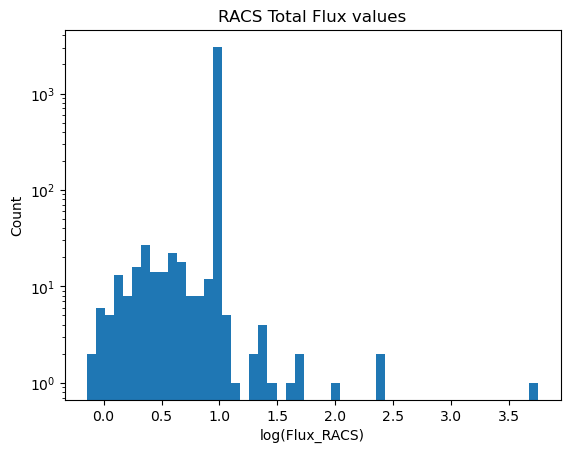

In [8]:
plt.hist(np.log10(Summary_table_hdu['RACS_TOTALFLUX']), bins=50, log=True)
plt.xlabel('log(Flux_RACS)')
plt.ylabel('Count')
plt.title('RACS Total Flux values')

### LARGESS v RACS flux

Text(0.5, 1.0, 'RACS v FIRST flux values')

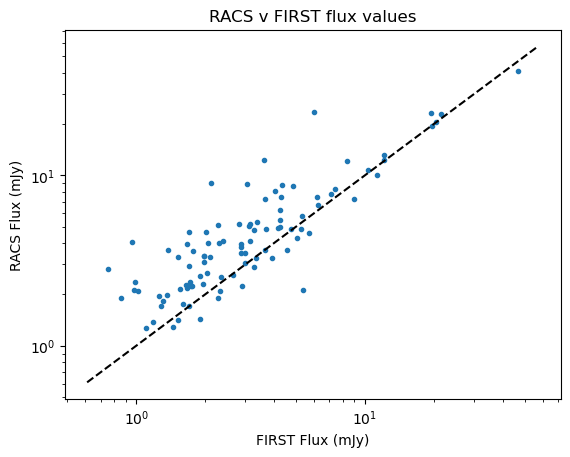

In [9]:
plt.loglog(Summary_table_hdu['FIRST_TOTALFLUX'], Summary_table_hdu['RACS_TOTALFLUX'], '.')

plt.xlabel('FIRST Flux (mJy)')
plt.ylabel('RACS Flux (mJy)')

xlims = plt.xlim()
ylims = plt.ylim()
plt.plot(xlims, xlims, 'k--')
plt.title('RACS v FIRST flux values')

In [10]:
save_file = False
if save_file:
    Summary_table_filename = f"SAMI_AGN_matches.fits"

    Summary_table_filepath = catalogue_filepath+"Crossmatched\\"+Summary_table_filename
    Summary_table_hdu.write(Summary_table_filepath)
    print(f"Summary Table Saved to: {Summary_table_filepath}")



## OLD CODE:

In [11]:
# #required strings and tables: 
# catalogue_filepath = Source_dir+"Catalogues\\"
# SAMI_spectra_catalogue = "EmissionLine1compDR3.fits"

# diagnostic_diagrams = ( ('BPT', 'N II'), ('BPT', 'S II'), ('BPT', 'O I'))

# source_types = ('Radio', 'XRay', 'LARGESS')

# Radio_catalogues = ("RACS-mid1_sources.fits", )
# LARGESS_catalogues = ("LARGESS.fits",)
# Xray_catalogues = ( "eRASS1_Main.v1.1.fits", )

# # format is Survey_type: (catalogue_filenames, max_sep_arcsec, position_colnames, catalogue_ID_col, flux_cols)
# crossmatching_survey_parameters = {'Radio':     ( Radio_catalogues,     5, ('RA', 'Dec'),       'Source_ID',    ('Total_flux', 'E_Total_flux') ), 
#                                    'LARGESS':   ( LARGESS_catalogues,   2, ('RAdeg', 'DEdeg'),  'Name',         ('imod', 'e_imod') ), 
#                                    'XRay':      ( Xray_catalogues,     15, ("RA", "DEC"),       'IAUNAME',      ('ML_FLUX_1', 'ML_FLUX_ERR_1')  )   }


# #variables
# SN_lim = 5 # signal noise limit for bpt diagrams
# save_file= True  


# #Initialise table with first 3 columns: 'CUBEID', 'CUBEIDPUB', 'CATID'

# with fits.open(catalogue_filepath+SAMI_spectra_catalogue) as SAMI_spectra_hdul:
#     SAMI_spectra_table_hdu =  Table(SAMI_spectra_hdul[1].data)
#     SAMI_spectra_table_hdu.sort('CATID')


# Summary_table_hdu = SAMI_spectra_table_hdu.copy()
# Summary_table_hdu.keep_columns(('CUBEID', 'CUBEIDPUB', 'CATID'))

# Summary_table_len = len(Summary_table_hdu)




# # BPT AGN columns: 

# '''
# IS_BPT_AGN - Flag to indicate 1.4 arcsec aperture emission data is located within the AGN region in a O[III]/[H\beta] v [NII]/[H\alpha] BPT diagram as defined in (Kewley, 2001)
# CATEGORY_BPT_AGN - Region galaxies 1.4 arcsec aperture emission data is located in on O[III]/[H\beta] v [NII]/[H\alpha] BPT diagram. Integer value is based on region in BPT:
# 									0 - Star-forming
# 									1 - located on Star-forming / Composite region boundary
# 									2 - Composite
# 									3 - located on Composite / AGN region boundary
# 									4 - LINER
# 									5 - Seyfert
# 									6 - located on LINER / Seyfert boundary                     
# IS_POSSIBLE_BPT_AGN - Flag to indicate 1.4 arcsec aperture emission data is located within AGN region in either [SII] or [OI] BPT diagrams as defined in (Kewley, 2001)
# WARN_BPT_SN	- Flag to indicate high-S/N (>5) of 1.4 arcsec aperture emission data used in O[III]/[H\beta] v [NII]/[H\alpha] BPT plot
# WARN_AGN_OTHER_BPT - Flag to indicate galaxy emission data is not located in AGN region in [SII]/[H\alpha] or [OI]/[H\alpha] BPT plots defined in (Kewley, 2001) 
# WARN_AGN_TYPE_OTHER_BPT - Flag to indicate galaxy emission data is not located in the same AGN type region in [SII]/[H\alpha] or [OI]/[H\alpha] BPT plots compared to [NII]/[H\alpha] BPT classification, bounds defined in (Kewley, 2006)
# '''


# OIII_flux, OIII_error = get_flux_and_error_1_4_ARCSEC(SAMI_spectra_table_hdu, 'O III')
# HBeta_flux, HBeta_error = get_flux_and_error_1_4_ARCSEC(SAMI_spectra_table_hdu, 'H Beta')
# HAlpha_flux, HAlpha_error = get_flux_and_error_1_4_ARCSEC(SAMI_spectra_table_hdu, 'H Alpha')


#     # initialise arrays for other BPT diagrams:
# possible_AGN_array = np.zeros(Summary_table_len, dtype=bool)
# Warning_not_AGN_other_BPT_array = np.zeros(Summary_table_len, dtype=bool)
# Warning_different_AGN_type_other_BPT_array = np.zeros(Summary_table_len, dtype=bool)

# for diagnostic_diagram in diagnostic_diagrams:
#     plot_type = diagnostic_diagram[0]
#     bpt_metal = diagnostic_diagram[1]

#     metal_flux, metal_error = get_flux_and_error_1_4_ARCSEC(SAMI_spectra_table_hdu, bpt_metal)

#     BPT_y = np.log10(OIII_flux/HBeta_flux)
#     BPT_x = np.log10(metal_flux/HAlpha_flux)

#     BPT_y_error = np.abs(BPT_y * np.sqrt( (OIII_error/OIII_flux)**2+(HBeta_error/HBeta_flux)**2))
#     BPT_x_error = np.abs(BPT_x * np.sqrt( (metal_error/metal_flux)**2+(HAlpha_error/HAlpha_flux)**2))

#     SN_array = np.max(np.array([BPT_y_error/BPT_y, BPT_x_error/BPT_x]), axis=0)

#     SN_flag = SN_array > SN_lim

#     galaxy_type_array, is_AGN_array = get_BPT_AGN_classification(BPT_x, BPT_x_error, BPT_y, BPT_y_error, metal = bpt_metal)
#     if bpt_metal == 'N II':
#         # set these array values as they will be used later to build the main BPT columns
#         Category_BPT_array = galaxy_type_array.copy()
#         Is_BPT_array = is_AGN_array.copy()
#         Warning_BPT_SN_array = SN_flag.copy()



#     else:
#         # update possible AGN array if is AGN in other BPT
#         possible_AGN_array = possible_AGN_array | is_AGN_array 

#         # update warning if not an AGN in other BPT (only if was originally considered an AGN)
#         Warning_not_AGN_other_BPT_array = Warning_not_AGN_other_BPT_array | (~is_AGN_array & Is_BPT_array) 

#         # update warning if different type of AGN in other BPT
#         same_AGN_type_array =  (Category_BPT_array == galaxy_type_array)
#         Warning_different_AGN_type_other_BPT_array = Warning_different_AGN_type_other_BPT_array | (~same_AGN_type_array & Is_BPT_array) 

# # IS_BPT_AGN
# Summary_table_hdu.add_column(astropy.table.Column(Is_BPT_array, name=f'IS_BPT_AGN', dtype=int))

# # CATEGORY_BPT_AGN
# Summary_table_hdu.add_column(astropy.table.Column(Category_BPT_array, name=f'CATEGORY_BPT_AGN', dtype=int))

# # IS_POSSIBLE_BPT_AGN
# Summary_table_hdu.add_column(astropy.table.Column(possible_AGN_array, name=f'IS_POSSIBLE_BPT_AGN', dtype=int))

# # WARN_BPT_SN
# Summary_table_hdu.add_column(astropy.table.Column(Warning_BPT_SN_array, name=f'WARN_BPT_SN', dtype=int))

# # WARN_AGN_OTHER_BPT
# Summary_table_hdu.add_column(astropy.table.Column(Warning_not_AGN_other_BPT_array, name=f'WARN_AGN_OTHER_BPT', dtype=int))

# # WARN_AGN_TYPE_OTHER_BPT
# Summary_table_hdu.add_column(astropy.table.Column(Warning_different_AGN_type_other_BPT_array, name=f'WARN_AGN_TYPE_OTHER_BPT', dtype=int))





# # CROSS-MATCHING Columns

#     # Use previously constructed catalogue summary table functions


# # iterate for every column
# for source_type in source_types:
#     #expand tuple of crossmatching_params
#     catalogue_filenames, max_sep_arcsec, position_colnames, catalogue_ID_col, flux_cols = crossmatching_survey_parameters[source_type]

#     survey_cols_to_keep = (catalogue_ID_col,)+flux_cols

#     # initialise array of is_in 

#     for crossmatching_catalogue in catalogue_filenames:
#         crossmatched_catalogue = get_all_SAMI_crossmatched_fits_table(Source_dir+"Catalogues\\", crossmatching_catalogue, max_sep_arcsec, position_colnames, save_file=False, only_closest=False, survey_cols_to_keep=survey_cols_to_keep)
        
# # IS_{source_type}SOURCE         
#         cube_is_crossmatched = np.isin(Summary_table_hdu['CATID'],crossmatched_catalogue['CATID'])*1
#         # WARN_AGN_TYPE_OTHER_BPT
#         Summary_table_hdu.add_column(astropy.table.Column(cube_is_crossmatched, name=f'IS_{source_type.upper()}SOURCE', dtype=int))

# # add the columns for source_type catalogue id
#         Summary_table_hdu = join(Summary_table_hdu, crossmatched_catalogue[('CATID', catalogue_ID_col)], join_type='left')
        
# # {source_type}_MATCHED_ID
#         Summary_table_hdu.rename_column(catalogue_ID_col, f'{source_type.upper()}_MATCHED_ID')
        

#         # for the right source type need to add total flux and flux error
#         if source_type in ('Radio', 'XRay'):

# # add the columns for source_type total flux and total flux error 
#             Summary_table_hdu = join(Summary_table_hdu, crossmatched_catalogue[('CATID', flux_cols[0], flux_cols[1])], join_type='left')



# # {source_type}_TOTALFLUX
#             Summary_table_hdu.rename_column(flux_cols[0], f'{source_type.upper()}_TOTALFLUX')

# # {source_type}_TOTALFLUX_ERR
#             Summary_table_hdu.rename_column(flux_cols[1], f'{source_type.upper()}_TOTALFLUX_ERR')

# save_file = False
# if save_file:
#     Summary_table_filename = f"SAMI_AGN_matches.fits"

#     Summary_table_filepath = catalogue_filepath+"Crossmatched\\"+Summary_table_filename
#     Summary_table_hdu.write(Summary_table_filepath)
#     print(f"Summary Table Saved to: {Summary_table_filepath}")



# Summary_table_hdu

In [12]:
np.sum(np.isin(crossmatched_catalogue['SAMI_region'], ('Cluster', 'Filler', 'GAMA')))


crossmatched_catalogue
test = Summary_table_hdu['CATID', 'IS_BPT_AGN', 'CATEGORY_BPT_AGN']
test[test['IS_BPT_AGN'] == 0]

KeyError: 'SAMI_region'

In [ ]:
Summary_BPT_table_hdu
#Summary_BPT_table_hdu[Summary_BPT_table_hdu['CATID'] == 56140]

print(np.sum(np.isin(Summary_BPT_table_hdu['CUBEIDPUB'], Summary_table_hdu['CUBEIDPUB'])))

test_table = join(Summary_BPT_table_hdu, Summary_table_hdu, keys=('CATID'), join_type='left')

print(np.sum(test_table['CUBEIDPUB_1'][0] == '6821_A'))

test_table['CUBEIDPUB_2'][0]
test_table['CUBEIDPUB_1', 'CUBEIDPUB_2']


3067
1


CUBEIDPUB_1,CUBEIDPUB_2
str12,str16
6821_A,6821_A
6837_A,6837_A
7139_A,7139_A
7206_A,7206_A
7289_A,7289_A
7715_A,7715_A
7839_A,7839_A
7841_A,7841_A
7946_A,7946_A


## Broadlines

In [ ]:
broadlines = [238358, 298590, 323854, 3631902, 376679, 463148, 491508, 718921, 9008500673, 9011900430, 9016800276]
test_table = Summary_table_hdu[np.isin(Summary_table_hdu['CATID'], broadlines)]
#Summary_table_hdu
#Summary_BPT_table_hdu

#test_table['CUBEID'][0] == test_table['CUBEID'][1]

#Summary_BPT_table_hdu[Summary_BPT_table_hdu['CATID'] == 10000001]
#print(np.sum(Summary_table_hdu['IS_BPT_AGN'] == 0)+ np.sum(Summary_table_hdu['IS_BPT_AGN'] == 1) + np.sum(Summary_table_hdu['IS_BPT_AGN'].mask))
test_table

CUBEIDPUB,CUBEID,CATID,IS_BPT_AGN,CATEGORY_BPT_AGN,IS_OTHER_BPT_AGN,WARN_BPT_SN,WARN_AGN_OTHER_BPT,WARN_AGN_TYPE_OTHER_BPT,IS_RADIOSOURCE,RACS_MATCHED_ID,RACS_TOTALFLUX,RACS_TOTALFLUX_ERR,RACS_SOURCE_CLASSIFICATION,IS_XRAYSOURCE,eROSITA_MATCHED_ID,eROSITA_TOTALFLUX_1,eROSITA_TOTALFLUX_1_ERR,eROSITA_TOTALFLUX_2,eROSITA_TOTALFLUX_2_ERR,eROSITA_TOTALFLUX_3,eROSITA_TOTALFLUX_3_ERR,IS_LARGESSSOURCE,LARGESS_MATCHED_ID,LARGESS_imod,LARGESS_e_imod,N_FIRST,FIRST_TOTALFLUX,N_NVSS,NVSS_TOTALFLUX,IS_BROADLINE_AGN,M_STAR,Z_SPEC,SFR_SAMI,SFR_SAMI_FLAG
str16,str80,int64,int64,int64,int64,int64,int64,int64,int64,str17,float64,float64,str1,int64,str23,float32,float32,float32,float32,float32,float32,int64,str19,float64,float64,int64,float64,int64,float64,int64,float32,float64,float64,float64
238358_A,238358_7_Y13SAR1_P012_15T012_2013_04_12-2013_04_16,238358,1,6,1,0,0,1,1,RACS_1419+00_2408,2.922140312110341,0.5338929870920224,S,1,1eRASS J141630.6+013710,6.2745604e-13,6.3117283e-14,3.1658527e-13,1.3903653e-13,0.0,2.5925597e-13,1,J141630.81+013707.9,14.344,0.003,1,1.7,1,3.1,1,10.78,0.03922000154852867,0.6102894805692318,1.0
298590_A,298590_7_Y15SAR4_P004_15T113_2016_03_03-2016_03_13,298590,0,3,1,0,0,0,0,--,--,--,--,1,1eRASS J144242.6+011910,3.5635142e-13,4.6606758e-14,8.350063e-14,7.415122e-14,4.9619586e-13,4.824728e-13,0,--,--,--,--,--,--,--,1,10.55,0.035280000418424606,-0.08093088327020487,0.0
323854_A,323854_7_Y14SBR2_P002_09T089_2015_01_19-2015_01_26,323854,1,6,0,0,1,1,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,1,10.71,0.08622000366449356,0.2790517940067508,0.0
376679_A,376679_7_Y15SAR1_P002_09T098_2016_03_03-2016_03_13,376679,1,7,0,0,1,1,1,RACS_0857+00_1658,2.5507390821431613,0.48286752164642865,S,1,1eRASS J085836.0+013146,4.0587142e-14,2.374678e-14,0.0,7.1658384e-14,5.8665974e-13,1.1038711e-12,1,J085835.98+013149.5,15.198,0.004,1,1.91,0,-99.0,1,11.09,0.07709000259637833,1.1500483620044273,1.0
463148_A,463148_6_Y14SAR4_P004_15T090_2014_05_23-2014_06_01,463148,1,7,1,0,0,0,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,1,10.02,0.005760000087320805,-0.31600801552268526,0.0
491508_A,491508_6_Y14SAR4_P004_15T090_2014_05_23-2014_06_01,491508,0,2,0,0,0,0,1,RACS_1358+00_567,1.1365019242516479,0.25784187097195527,S,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,1,10.61,0.028279999271035194,0.47408460250297085,0.0
718921_A,718921_7_Y17SAR3_P010_15T133_2018_05_07-2018_05_16,718921,0,-1,0,0,0,0,1,RACS_1419+00_646,2.302553449354643,0.5093354501104744,S,1,1eRASS J142906.6+011706,7.3452884e-12,2.0870828e-13,3.2169848e-12,4.1740933e-13,2.2749621e-12,1.0761278e-12,1,J142906.57+011706.0,13.848,0.004,1,1.95,1,2.7,1,11.19,0.07569000124931335,1.655106813873339,1.0
3631902_A,3631902_6_Y18SAR1_P002_09T140_2018_04_09-2018_04_19,3631902,1,7,1,0,0,0,0,--,--,--,--,1,1eRASS J091135.1-005157,6.153012e-14,2.9726194e-14,9.984271e-14,1.1211958e-13,0.0,6.378549e-13,0,--,--,--,--,--,--,--,1,10.36,0.05583000183105469,0.22983396262755837,1.0
9008500673_A,9008500673_10_Y14SBR1_P003_A0085T008_2014_10_21-2014_10_26,9008500673,0,2,0,0,0,0,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,1,10.771184,0.0449310801923275,0.5275430300548675,0.0


In [ ]:
np.unique(SAMI_spectra_table_hdu['CATID'])

6821
6837
7139
7206
7289
7715
7839
7841
7946
7969
7992


In [ ]:
import astropy.units as u
from astropy import constants as const
import numpy as np

M_sun = const.M_sun
a_0 = 1e-10 *u.m * u.s**(-2)

r = np.sqrt(const.G * M_sun /a_0)
print(r.to(u.AU))

7700.703551074278 AU


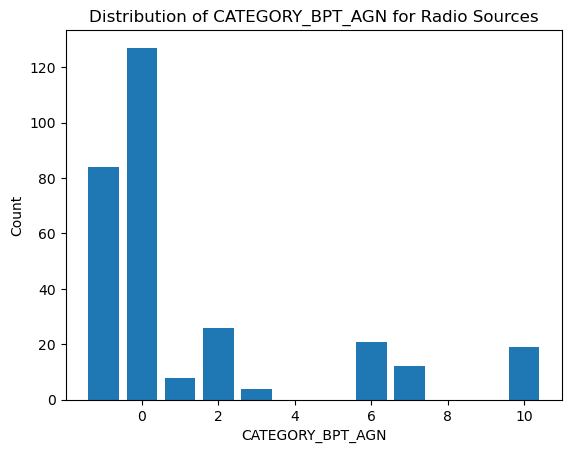

In [67]:
Summary_table_hdu_radiomatches = Summary_table_hdu[Summary_table_hdu['IS_RADIOSOURCE'] == 1]

# Get the column as a numpy array
categories = np.array(Summary_table_hdu_radiomatches['CATEGORY_BPT_AGN'])

# Count occurrences of each unique value
unique, counts = np.unique(categories, return_counts=True)

# Create the bar plot
plt.bar(unique, counts)
plt.xlabel('CATEGORY_BPT_AGN')
plt.ylabel('Count')
plt.title('Distribution of CATEGORY_BPT_AGN for Radio Sources')
plt.show()



In [ ]:
np.sum(counts[np.isin(unique, (6,7,8,9,10))])

np.int64(46)

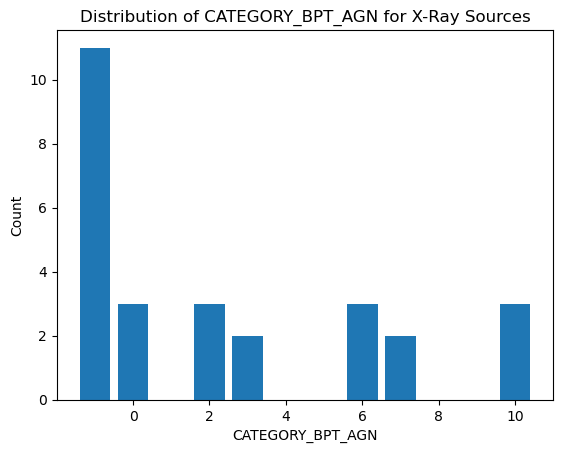

np.int64(8)

In [68]:
Summary_table_hdu_xraymatches = Summary_table_hdu[Summary_table_hdu['IS_XRAYSOURCE'] == 1]

# Get the column as a numpy array
categories = np.array(Summary_table_hdu_xraymatches['CATEGORY_BPT_AGN'])

# Count occurrences of each unique value
unique, counts = np.unique(categories, return_counts=True)

# Create the bar plot
plt.bar(unique, counts)
plt.xlabel('CATEGORY_BPT_AGN')
plt.ylabel('Count')
plt.title('Distribution of CATEGORY_BPT_AGN for X-Ray Sources')
plt.show()

np.sum(counts[np.isin(unique, (6,7,8,9,10))])

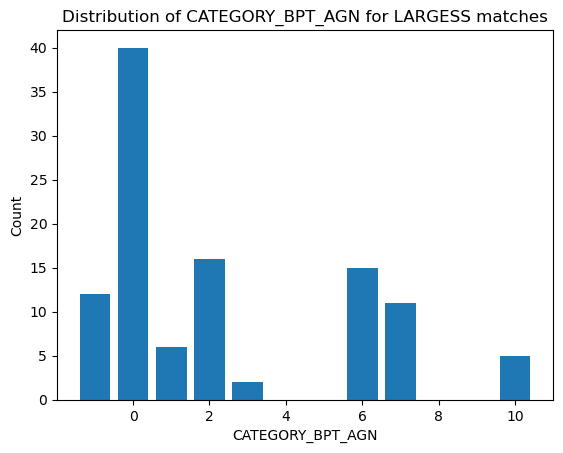

np.int64(31)

In [14]:
Summary_table_hdu_LARGESSmatches = Summary_table_hdu[Summary_table_hdu['IS_LARGESSSOURCE'] == 1]

# Get the column as a numpy array
categories = np.array(Summary_table_hdu_LARGESSmatches['CATEGORY_BPT_AGN'])

# Count occurrences of each unique value
unique, counts = np.unique(categories, return_counts=True)

# Create the bar plot
plt.bar(unique, counts)
plt.xlabel('CATEGORY_BPT_AGN')
plt.ylabel('Count')
plt.title('Distribution of CATEGORY_BPT_AGN for LARGESS matches')
plt.show()

np.sum(counts[np.isin(unique, (6,7,8,9,10))])

In [15]:
HII_CATIDs = [9163, 9352, 14555]
Seyfert2_CATIDs = [209698, 388424, 396833, 376478, 347769, 388200]
Seyfert1_CATIDs = [137809, 376679, 238358, 3631902, 718921]
LINER_CATIDs = [91589, 99428, 106549, 107528, 136880, 220330]


catalogue_filepath = Source_dir+"Catalogues\\"
with fits.open(catalogue_filepath + "ALL_SAMI_TARGETS.fits") as all_SAMI_targets_hdul:
    all_SAMI_target_table = Table(all_SAMI_targets_hdul[1].data)

new_table = all_SAMI_target_table.copy()
new_table.keep_columns(('CATID', 'RA_OBJ', 'DEC_OBJ'))
new_table[np.isin(new_table['CATID'], LINER_CATIDs)]

CATID,RA_OBJ,DEC_OBJ
int64,float64,float64
220330,181.10492248,1.6473063
136880,176.33707383,-1.81279084
106549,216.55409249,0.8605753
91589,212.79368649,0.57878925
99428,182.76693192,0.97233591
107528,220.59837241,0.90799816


c:\Users\mspan\OneDrive - The University of Sydney (Students)\Honours\Honours Project\sami_tools_smc_mspa4681\Code\all_fctns.py:196: RuntimeWarning: invalid value encountered in log10
  logBPT_y_min = np.log10(BPT_y - BPT_y_error)
c:\Users\mspan\OneDrive - The University of Sydney (Students)\Honours\Honours Project\sami_tools_smc_mspa4681\Code\all_fctns.py:199: RuntimeWarning: invalid value encountered in log10
  logBPT_x_min = np.log10(BPT_x - BPT_x_error)


CUBEIDPUB,CUBEID,CATID,IS_BPT_AGN,CATEGORY_BPT_AGN,IS_OTHER_BPT_AGN,WARN_BPT_SN,WARN_AGN_OTHER_BPT,WARN_AGN_TYPE_OTHER_BPT,IS_RADIOSOURCE,IS_RACSSOURCE,RACS_MATCHED_ID,RACS_TOTALFLUX,RACS_TOTALFLUX_ERR,RACS_SOURCE_CLASSIFICATION,IS_LARGESSSOURCE,LARGESS_MATCHED_ID,LARGESS_imod,LARGESS_e_imod,N_FIRST,FIRST_TOTALFLUX,N_NVSS,NVSS_TOTALFLUX,IS_XRAYSOURCE,eRASS1_MATCHED_ID,eRASS1_TOTALFLUX_1,eRASS1_TOTALFLUX_1_ERR,eRASS1_TOTALFLUX_2,eRASS1_TOTALFLUX_2_ERR,eRASS1_TOTALFLUX_3,eRASS1_TOTALFLUX_3_ERR,IS_BROADLINE_AGN,M_STAR,Z_SPEC,SFR_SAMI,SFR_SAMI_FLAG
str16,str80,int64,int64,int64,int64,int64,int64,int64,int64,int64,str17,float64,float64,str1,int64,str19,float64,float64,int64,float64,int64,float64,int64,str23,float32,float32,float32,float32,float32,float32,int64,float32,float64,float64,float64
6821_A,6821_7_Y18SAR4_P001_12T126_2018_05_07-2018_05_16,6821,0,0,1,0,0,0,0,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,0,7.42,0.004430000204592943,-0.8337829957020938,2.0
6837_A,6837_7_Y18SAR4_P001_12T126_2018_05_07-2018_05_16,6837,0,0,0,0,0,0,0,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,0,--,0.07423999905586243,-0.10811913977560492,1.0
7139_A,7139_7_Y18SAR3_P002_12T122_2018_05_07-2018_05_16,7139,1,6,1,0,0,0,0,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,0,10.63,0.07697000354528427,-1.4812175131637677,0.0
7206_A,7206_7_Y18SAR3_P002_12T122_2018_05_07-2018_05_16,7206,0,2,0,0,0,0,0,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,0,10.48,0.09470999985933304,0.5071057664992104,0.0
7289_A,7289_7_Y18SAR3_P002_12T122_2018_05_07-2018_05_16,7289,1,10,1,0,1,1,0,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,0,11.12,0.08812999725341797,-0.42963751393666283,0.0
7715_A,7715_7_Y14SAR4_P002_12T064_2014_05_23-2014_06_01,7715,0,-1,1,0,0,0,0,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,0,10.99,0.07926999777555466,-0.9876825301304426,0.0
7839_A,7839_7_Y16SAR4_P002_12T101_2017_04_19-2017_05_01,7839,1,6,1,0,1,1,1,0,--,--,--,--,1,J115827.70+004304.4,14.397,0.002,1,1.35,0,-99.0,0,--,--,--,--,--,--,--,0,11.05,0.048739999532699585,-0.9330332098451861,1.0
7841_A,7841_7_Y14SAR4_P002_12T064_2014_05_23-2014_06_01,7841,0,-1,0,0,0,0,0,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,0,10.96,0.0798100009560585,-1.3503192190613338,0.0
7946_A,7946_7_Y16SAR4_P002_12T101_2017_04_19-2017_05_01,7946,1,6,1,0,1,1,0,0,--,--,--,--,0,--,--,--,--,--,--,--,0,--,--,--,--,--,--,--,0,10.92,0.10426999628543854,0.07435618623620215,0.0
